In [1]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr
%matplotlib inline

In [2]:
pkg = mp.open_package('http://library.metatab.org/ceden.waterboards.ca.gov-beachwatch-sandiego-2.zip')

pkg

df = pkg.resource('beachwatch-sd').read_csv(parse_dates=True)

# It looks like the prefix of the station code groups stations, maybe into watersheds. 
df['stationgroup'] = df.stationcode.str[:2]

df = df[['stationcode','sampledate','methodname','unit','analyte','result']
# There many dates with multiple measures. They are probably distinguished by time, 
# but we don't really care about the time, so we'll add a measurement number for each group.
df['measure_no'] = df.groupby(['stationcode','sampledate','methodname','analyte']).cumcount()+1


In [3]:
# The results has a large range, so log transformation makes them easier to visualize.
df['log_result'] = df.result.apply(np.log)
df.head()

,stationcode,sampledate,methodname,unit,analyte,result,measure_no,log_result
0,EH-010,1999-04-02,MTF,MPN/100 mL,"Coliform, Total",300.0,1,5.703782
1,EH-010,1999-04-29,MTF,MPN/100 mL,"Coliform, Total",20.0,1,2.995732
2,EH-010,1999-04-30,MTF,MPN/100 mL,"Coliform, Total",20.0,1,2.995732
3,EH-010,1999-05-26,Enterolert,MPN/100 mL,Enterococcus,10.0,1,2.302585
4,EH-010,1999-05-26,MTF,MPN/100 mL,"Coliform, Fecal",20.0,1,2.995732


In [4]:
 _ = df.groupby(['stationcode','sampledate','methodname','analyte','unit']).agg({'result':['count','std','mean','median']})

_.columns = ['result_count', 'result_std', 'result_mean', 'result_median']
_.reset_index(inplace=True)
_.head()
_ = _[_.result_count>0] # Groupby produces values with count of 0?
_.head()
dfn = _

In [6]:
dfn[['methodname','analyte']].drop_duplicates().groupby('methodname').analyte.count()

methodname
Colilert-18    2
EPA 1600       1
Enterolert     1
MTF            4
SM 9221 B      1
SM 9221 E      3
SM 9222 B      4
SM 9222 D      3
Name: analyte, dtype: int64

In [7]:
dfn[['methodname','analyte']].drop_duplicates().groupby('analyte').methodname.count()

analyte
Coliform, Fecal    4
Coliform, Total    6
E. coli            4
Enterococcus       5
Name: methodname, dtype: int64

In [8]:
dfn[['methodname','unit']].drop_duplicates().groupby('unit').methodname.count()

unit
MPN/100 mL    6
cfu/100mL     8
Name: methodname, dtype: int64

In [9]:
dfn[dfn.stationcode=='EH-010'][['methodname','unit']].drop_duplicates().groupby('methodname').unit.count()

methodname
Colilert-18    1
Enterolert     2
MTF            1
SM 9221 B      2
SM 9221 E      2
SM 9222 B      1
Name: unit, dtype: int64

In [10]:
_ = dfn[['sampledate', 'stationcode','methodname','analyte','unit', 'result_median']]\
    .set_index(['sampledate','stationcode','analyte','methodname','unit']).unstack([2,3,4])

_.to_csv('results.csv')
dfs = _
_.head()

result_median                                  \
analyte                Coliform, Fecal Coliform, Total Coliform, Fecal   
methodname                   SM 9222 B       SM 9222 B             MTF   
unit                         cfu/100mL       cfu/100mL      MPN/100 mL   
sampledate stationcode                                                   
1998-07-21 SE-010                  NaN             NaN             4.0   
           SE-020                  NaN             NaN            23.0   
           SE-030                  NaN             NaN             2.0   
           SE-040                  NaN             NaN             2.0   
           SE-050                  NaN             NaN             2.0   

                                                                               \
analyte                Coliform, Total Enterococcus           Coliform, Total   
methodname                         MTF   Enterolert SM 9222 B       SM 9221 B   
unit                        MPN/100 mL   MPN/100 mL cfu/100mL      MPN/100 mL   
sampledate stationcode                                                          
1998-07-21 SE-010                  4.0          NaN       NaN             NaN   
           SE-020                 23.0          NaN       NaN             NaN   
           SE-030                  2.0          NaN       NaN             NaN   
           SE-040                  2.0          NaN       NaN             NaN   
           SE-050                  2.0          NaN       NaN             NaN   

                                                                    \
analyte                Coliform, Fecal Coliform, Total     E. coli   
methodname                   SM 9221 E     Colilert-18 Colilert-18   
unit                        MPN/100 mL      MPN/100 mL  MPN/100 mL   
sampledate stationcode                                               
1998-07-21 SE-010                  NaN             NaN         NaN   
           SE-020                  NaN             NaN         NaN   
           SE-030                  NaN             NaN         NaN   
           SE-040                  NaN             NaN         NaN   
           SE-050                  NaN             NaN         NaN   

                           ...                                    \
analyte                    ...      Coliform, Fecal Enterococcus   
methodname                 ...            SM 9222 B     EPA 1600   
unit                       ...           MPN/100 mL    cfu/100mL   
sampledate stationcode     ...                                     
1998-07-21 SE-010          ...                  NaN          NaN   
           SE-020          ...                  NaN          NaN   
           SE-030          ...                  NaN          NaN   
           SE-040          ...                  NaN          NaN   
           SE-050          ...                  NaN          NaN   

                                                                    \
analyte                Coliform, Fecal Coliform, Total               
methodname                   SM 9222 D       SM 9222 D Colilert-18   
unit                         cfu/100mL       cfu/100mL   cfu/100mL   
sampledate stationcode                                               
1998-07-21 SE-010                  NaN             NaN         NaN   
           SE-020                  NaN             NaN         NaN   
           SE-030                  NaN             NaN         NaN   
           SE-040                  NaN             NaN         NaN   
           SE-050                  NaN             NaN         NaN   

                                                                      \
analyte                    E. coli            Enterococcus   E. coli   
methodname             Colilert-18        MTF          MTF SM 9222 B   
unit                     cfu/100mL MPN/100 mL    cfu/100mL cfu/100mL   
sampledate stationcode                                                 
1998-07-21 SE-010             

In [11]:
dfs.corr().sort_index(axis=1,level='analyte').sort_index(axis=0,level='analyte')

result_median  \
analyte                                              Coliform, Fecal   
methodname                                                       MTF   
unit                                                      MPN/100 mL   
              analyte         methodname  unit                         
result_median Coliform, Fecal MTF         MPN/100 mL        1.000000   
                                          cfu/100mL              NaN   
                              SM 9221 E   MPN/100 mL       -0.172601   
                                          cfu/100mL              NaN   
                              SM 9222 B   MPN/100 mL       -0.160607   
                                          cfu/100mL        -0.014951   
                              SM 9222 D   cfu/100mL              NaN   
              Coliform, Total Colilert-18 MPN/100 mL        0.021776   
                                          cfu/100mL              NaN   
                              MTF         MPN/100 mL        0.799410   
                                          cfu/100mL              NaN   
                              SM 9221 B   MPN/100 mL       -0.110193   
                                          cfu/100mL              NaN   
                              SM 9221 E   MPN/100 mL             NaN   
                              SM 9222 B   MPN/100 mL       -0.110071   
                                          cfu/100mL        -0.019630   
                              SM 9222 D   cfu/100mL              NaN   
              E. coli         Colilert-18 MPN/100 mL        0.032160   
                                          cfu/100mL              NaN   
                              MTF         MPN/100 mL       -1.000000   
                              SM 9221 E   MPN/100 mL             NaN   
                              SM 9222 B   cfu/100mL              NaN   
              Enterococcus    EPA 1600    cfu/100mL              NaN   
                              Enterolert  MPN/100 mL        0.861757   
                                          cfu/100mL              NaN   
                              MTF         MPN/100 mL        0.011243   
                                          cfu/100mL        -0.166667   
                              SM 9222 B   MPN/100 mL        0.228683   
                                          cfu/100mL         0.100759   
                              SM 9222 D   cfu/100mL              NaN   

                                                                           \
analyte                                                                     
methodname                                                      SM 9221 E   
unit                                                 cfu/100mL MPN/100 mL   
              analyte         methodname  unit                              
result_median Coliform, Fecal MTF         MPN/100 mL       NaN  -0.172601   
                                          cfu/100mL   1.000000        NaN   
                              SM 9221 E   MPN/100 mL       NaN   1.000000   
                                          cfu/100mL        NaN        NaN   
                              SM 9222 B   MPN/100 mL       NaN        NaN   
                                          cfu/100mL        NaN  -0.003021   
                              SM 9222 D   cfu/100mL        NaN   0.999305   
              Coliform, Total Colilert-18 MPN/100 mL       NaN   0.994995   
                                          cfu/100mL        NaN        NaN   
                              MTF         MPN/100 mL       NaN  -0.143739   
                                          cfu/100mL   0.780063        NaN   
                              SM 9221 B   MPN/100 mL       NaN   0.990520   
                                          cfu/100mL        NaN        NaN   
                              SM 9221 E   MPN/100 mL       NaN   0.999983   
                              SM 9222 B   MPN/100 mL       NaN        N

In [12]:
dfs.notnull().sum(axis=0).to_frame().sort_index()

0
              analyte         methodname  unit             
result_median Coliform, Fecal MTF         MPN/100 mL  18753
                                          cfu/100mL      57
                              SM 9221 E   MPN/100 mL  22497
                                          cfu/100mL    1983
                              SM 9222 B   MPN/100 mL     84
                                          cfu/100mL   15294
                              SM 9222 D   cfu/100mL    1599
              Coliform, Total Colilert-18 MPN/100 mL   4060
                                          cfu/100mL       9
                              MTF         MPN/100 mL  18784
                                          cfu/100mL      60
                              SM 9221 B   MPN/100 mL  22547
                                          cfu/100mL    1979
                              SM 9221 E   MPN/100 mL      4
                              SM 9222 B   MPN/100 mL     91
                                          cfu/100mL   16762
                              SM 9222 D   cfu/100mL      41
              E. coli         Colilert-18 MPN/100 mL   4133
                                          cfu/100mL       5
                              MTF         MPN/100 mL      9
                              SM 9221 E   MPN/100 mL      6
                              SM 9222 B   cfu/100mL       4
              Enterococcus    EPA 1600    cfu/100mL    1591
                              Enterolert  MPN/100 mL  38839
                                          cfu/100mL    2020
                              MTF         MPN/100 mL   4659
                                          cfu/100mL      36
                              SM 9222 B   MPN/100 mL    100
                                          cfu/100mL   15581
                              SM 9222 D   cfu/100mL       1

In [13]:
dfs.notnull().sum(axis=0).to_frame().sort_values(0, ascending=False)

0
              analyte         methodname  unit             
result_median Enterococcus    Enterolert  MPN/100 mL  38839
              Coliform, Total SM 9221 B   MPN/100 mL  22547
              Coliform, Fecal SM 9221 E   MPN/100 mL  22497
              Coliform, Total MTF         MPN/100 mL  18784
              Coliform, Fecal MTF         MPN/100 mL  18753
              Coliform, Total SM 9222 B   cfu/100mL   16762
              Enterococcus    SM 9222 B   cfu/100mL   15581
              Coliform, Fecal SM 9222 B   cfu/100mL   15294
              Enterococcus    MTF         MPN/100 mL   4659
              E. coli         Colilert-18 MPN/100 mL   4133
              Coliform, Total Colilert-18 MPN/100 mL   4060
              Enterococcus    Enterolert  cfu/100mL    2020
              Coliform, Fecal SM 9221 E   cfu/100mL    1983
              Coliform, Total SM 9221 B   cfu/100mL    1979
              Coliform, Fecal SM 9222 D   cfu/100mL    1599
              Enterococcus    EPA 1600    cfu/100mL    1591
                              SM 9222 B   MPN/100 mL    100
              Coliform, Total SM 9222 B   MPN/100 mL     91
              Coliform, Fecal SM 9222 B   MPN/100 mL     84
              Coliform, Total MTF         cfu/100mL      60
              Coliform, Fecal MTF         cfu/100mL      57
              Coliform, Total SM 9222 D   cfu/100mL      41
              Enterococcus    MTF         cfu/100mL      36
              Coliform, Total Colilert-18 cfu/100mL       9
              E. coli         MTF         MPN/100 mL      9
                              SM 9221 E   MPN/100 mL      6
                              Colilert-18 cfu/100mL       5
              Coliform, Total SM 9221 E   MPN/100 mL      4
              E. coli         SM 9222 B   cfu/100mL       4
              Enterococcus    SM 9222 D   cfu/100mL       1

In [14]:
# Count the non-null rows for each analyte/method/unit combination, and pick the top counts
# to create a mask to select columns from the main dataset. 
_ = (dfs.notnull().sum(axis=0).to_frame()      # Sum nonnulls, True -> 1, False -> 0
       .sort_values(0, ascending=False))  # Sort by counts, take top 8

mask = _[_[0] > 1000].sort_index() # Take combination with more than 1K measurements

mask

0
              analyte         methodname  unit             
result_median Coliform, Fecal MTF         MPN/100 mL  18753
                              SM 9221 E   MPN/100 mL  22497
                                          cfu/100mL    1983
                              SM 9222 B   cfu/100mL   15294
                              SM 9222 D   cfu/100mL    1599
              Coliform, Total Colilert-18 MPN/100 mL   4060
                              MTF         MPN/100 mL  18784
                              SM 9221 B   MPN/100 mL  22547
                                          cfu/100mL    1979
                              SM 9222 B   cfu/100mL   16762
              E. coli         Colilert-18 MPN/100 mL   4133
              Enterococcus    EPA 1600    cfu/100mL    1591
                              Enterolert  MPN/100 mL  38839
                                          cfu/100mL    2020
                              MTF         MPN/100 mL   4659
                              SM 9222 B   cfu/100mL   15581

In [15]:
dfs[mask.T.columns].corr()

result_median  \
analyte                                              Coliform, Fecal   
methodname                                                       MTF   
unit                                                      MPN/100 mL   
              analyte         methodname  unit                         
result_median Coliform, Fecal MTF         MPN/100 mL        1.000000   
                              SM 9221 E   MPN/100 mL       -0.172601   
                                          cfu/100mL              NaN   
                              SM 9222 B   cfu/100mL        -0.014951   
                              SM 9222 D   cfu/100mL              NaN   
              Coliform, Total Colilert-18 MPN/100 mL        0.021776   
                              MTF         MPN/100 mL        0.799410   
                              SM 9221 B   MPN/100 mL       -0.110193   
                                          cfu/100mL              NaN   
                              SM 9222 B   cfu/100mL        -0.019630   
              E. coli         Colilert-18 MPN/100 mL        0.032160   
              Enterococcus    EPA 1600    cfu/100mL              NaN   
                              Enterolert  MPN/100 mL        0.861757   
                                          cfu/100mL              NaN   
                              MTF         MPN/100 mL        0.011243   
                              SM 9222 B   cfu/100mL         0.100759   

                                                                           \
analyte                                                                     
methodname                                            SM 9221 E             
unit                                                 MPN/100 mL cfu/100mL   
              analyte         methodname  unit                              
result_median Coliform, Fecal MTF         MPN/100 mL  -0.172601       NaN   
                              SM 9221 E   MPN/100 mL   1.000000       NaN   
                                          cfu/100mL         NaN  1.000000   
                              SM 9222 B   cfu/100mL   -0.003021       NaN   
                              SM 9222 D   cfu/100mL    0.999305       NaN   
              Coliform, Total Colilert-18 MPN/100 mL   0.994995       NaN   
                              MTF         MPN/100 mL  -0.143739       NaN   
                              SM 9221 B   MPN/100 mL   0.990520       NaN   
                                          cfu/100mL         NaN  0.821570   
                              SM 9222 B   cfu/100mL    0.098744       NaN   
              E. coli         Colilert-18 MPN/100 mL   0.999998       NaN   
              Enterococcus    EPA 1600    cfu/100mL    0.999984       NaN   
                              Enterolert  MPN/100 mL   0.100753       NaN   
                                          cfu/100mL         NaN  0.653093   
                              MTF         MPN/100 mL   0.808775       NaN   
                              SM 9222 B   cfu/100mL    0.377557       NaN   

                                                                          \
analyte                                                                    
methodname                                           SM 9222 B SM 9222 D   
unit                                                 cfu/100mL cfu/100mL   
              analyte         methodname  unit                             
result_median Coliform, Fecal MTF         MPN/100 mL -0.014951       NaN   
                              SM 9221 E   MPN/100 mL -0.003021  0.999305   
                                          cfu/100mL        NaN       NaN   
                              SM 9222 B   cfu/100mL   1.000000       NaN   
                              SM 9222 D   cfu/100mL        NaN  1.000000   
              Coliform, Total Colilert-18 MPN/100 mL -0.014443       NaN   
                              MTF         MPN/100 mL -0.023603       NaN   
            

In [16]:
len(dfs[mask.T.columns])

63378

In [17]:
dfs[mask.T.columns].reset_index().stationcode.value_counts().head()

IB-080    1609
FM-010    1118
OC-100    1098
EH-420    1023
SE-060    1004
Name: stationcode, dtype: int64

In [18]:
def plot_nullmap(df, group, resample=True):

    _ = df[mask.T.columns].reset_index()
    _ = _[_.stationcode==group].set_index('sampledate')

    if resample:
        _ = _.resample('1d').max()
    
    fig, ax = plt.subplots(figsize=(15,.5*len(_.columns)))
    sns.heatmap(_.isnull().T,cbar=False,xticklabels=False,cmap = 'viridis', ax=ax )
    

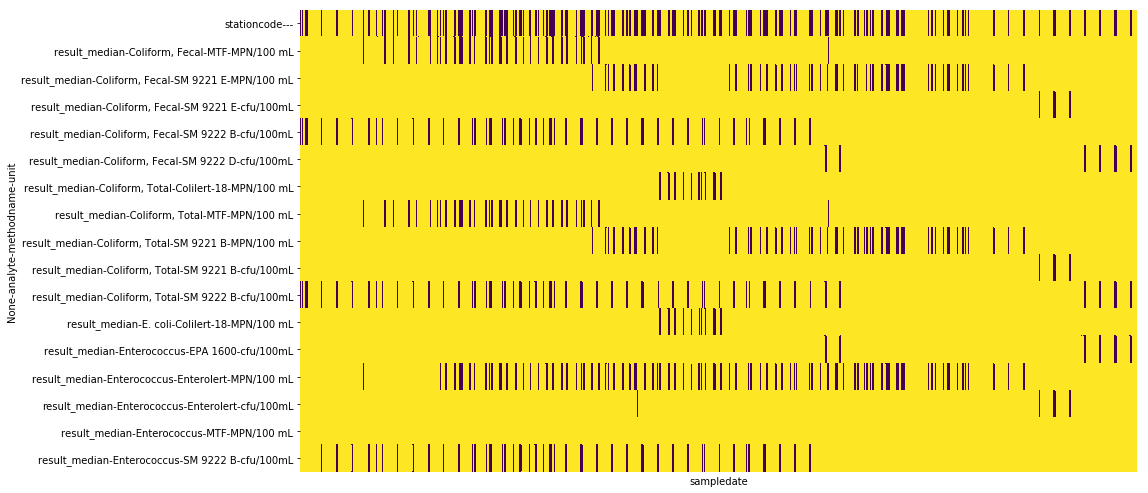

In [19]:
 plot_nullmap(dfs, 'IB-080')

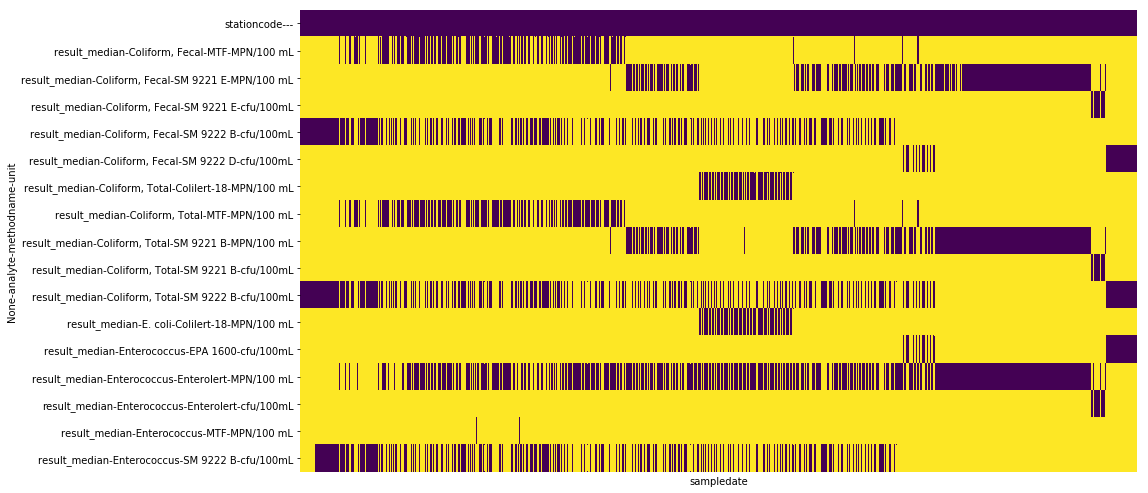

In [20]:
 plot_nullmap(dfs, 'IB-080', resample=False)

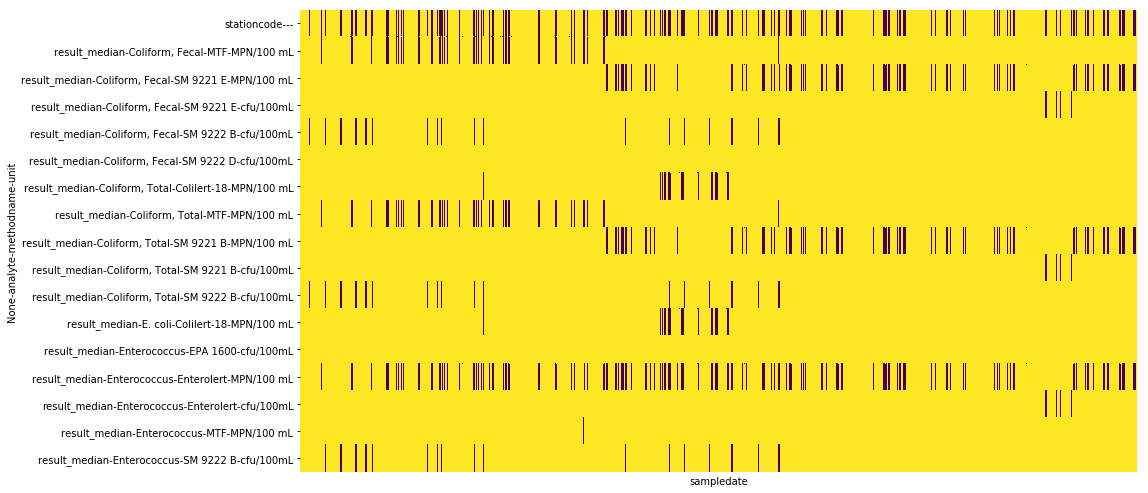

In [21]:
 plot_nullmap(dfs, 'FM-010')

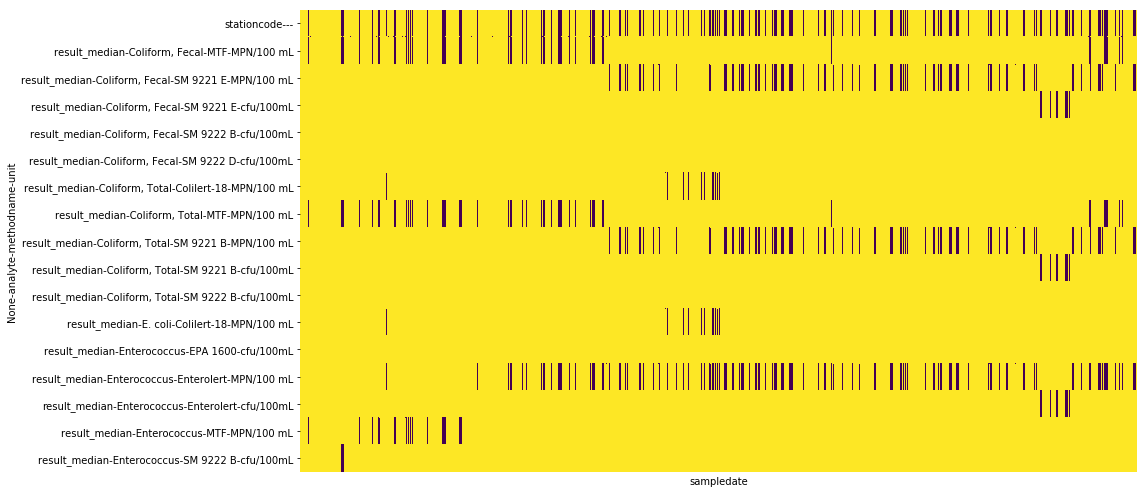

In [22]:
 plot_nullmap(dfs, 'OC-100')

In [23]:
df.head()

,stationcode,sampledate,methodname,unit,analyte,result,measure_no,log_result
0,EH-010,1999-04-02,MTF,MPN/100 mL,"Coliform, Total",300.0,1,5.703782
1,EH-010,1999-04-29,MTF,MPN/100 mL,"Coliform, Total",20.0,1,2.995732
2,EH-010,1999-04-30,MTF,MPN/100 mL,"Coliform, Total",20.0,1,2.995732
3,EH-010,1999-05-26,Enterolert,MPN/100 mL,Enterococcus,10.0,1,2.302585
4,EH-010,1999-05-26,MTF,MPN/100 mL,"Coliform, Fecal",20.0,1,2.995732


In [26]:
df.groupby([ 'stationcode','methodname','analyte','unit']).mean()[['result']].sort_index(level=['stationcode','analyte']).sort_values('result',ascending=False)

result
stationcode methodname  analyte         unit                    
TJ-030      Colilert-18 Coliform, Total cfu/100mL   1.430567e+07
TJ-020      SM 9221 B   Coliform, Total MPN/100 mL  1.246167e+07
            Colilert-18 Coliform, Total cfu/100mL   1.044010e+07
TJ-030      SM 9221 B   Coliform, Total MPN/100 mL  1.012373e+07
TJ-020      Colilert-18 Coliform, Total MPN/100 mL  6.256108e+06
TJ-030      Colilert-18 Coliform, Total MPN/100 mL  5.353244e+06
TJ-020      SM 9221 E   Coliform, Fecal MPN/100 mL  3.010667e+06
            MTF         Coliform, Total MPN/100 mL  2.970978e+06
TJ-030      MTF         Coliform, Total MPN/100 mL  2.531286e+06
TJ-020      Colilert-18 E. coli         MPN/100 mL  1.764600e+06
TJ-030      Colilert-18 E. coli         MPN/100 mL  1.425337e+06
TJ-020      SM 9222 B   Coliform, Total cfu/100mL   1.263319e+06
            MTF         Coliform, Fecal MPN/100 mL  1.010936e+06
TJ-030      MTF         Coliform, Fecal MPN/100 mL  9.759451e+05
TJ-020      Colilert-18 E. coli         cfu/100mL   7.270000e+05
TJ-030      SM 9222 B   Coliform, Total cfu/100mL   7.251800e+05
TJ-020      SM 9222 B   Coliform, Fecal cfu/100mL   6.582886e+05
            MTF         E. coli         MPN/100 mL  4.945300e+05
TJ-030      SM 9222 B   Coliform, Fecal cfu/100mL   3.556144e+05
EH-330      SM 9221 B   Coliform, Total MPN/100 mL  3.107767e+05
EH-475      SM 9222 B   Coliform, Total cfu/100mL   2.462996e+05
OC-035      MTF         Coliform, Total MPN/100 mL  1.600000e+05
EH-330      SM 9221 E   Coliform, Fecal MPN/100 mL  1.447225e+05
            MTF         Coliform, Total MPN/100 mL  1.121482e+05
TJ-030      Colilert-18 E. coli         cfu/100mL   1.046200e+05
            MTF         E. coli         MPN/100 mL  9.330000e+04
EH-340      MTF         Coliform, Total MPN/100 mL  8.982706e+04
FM-100      Colilert-18 Coliform, Total cfu/100mL   7.675000e+04
EH-477      SM 9221 B   Coliform, Total MPN/100 mL  6.175550e+04
EH-470      MTF         Enterococcus    MPN/100 mL  5.120000e+04
...                                                          ...
EN-050      SM 9222 B   Coliform, Fecal MPN/100 mL  1.000000e+00
EN-020      SM 9222 B   Coliform, Fecal MPN/100 mL  1.000000e+00
EH-410      MTF         Coliform, Fecal cfu/100mL   1.000000e+00
EN-020      SM 9222 B   Coliform, Total MPN/100 mL  1.000000e+00
EN-010      SM 9222 B   Enterococcus    MPN/100 mL  1.000000e+00
OC-080      SM 9222 B   Enterococcus    MPN/100 mL  1.000000e+00
EN-040      SM 9222 B   Enterococcus    MPN/100 mL  1.000000e+00
SC-010      SM 9221 E   Coliform, Fecal MPN/100 mL  1.000000e+00
            SM 9221 B   Coliform, Total MPN/100 mL  1.000000e+00
EN-020      SM 9222 B   Enterococcus    MPN/100 mL  1.000000e+00
EH-405      MTF         Coliform, Fecal cfu/100mL   1.000000e+00
SC-010      Enterolert  Enterococcus    MPN/100 mL  1.000000e+00
OC-050      SM 9222 B   Enterococcus    MPN/100 mL  1.000000e+00
OC-010      MTF         Enterococcus    cfu/100mL   1.000000e+00
OC-020      SM 9222 B   Enterococcus    MPN/100 mL  1.000000e+00
EN-010      SM 9222 B   Coliform, Fecal MPN/100 mL  1.000000e+00
EH-150      SM 9222 B   Coliform, Total MPN/100 mL  0.000000e+00
            MTF         Coliform, Total MPN/100 mL  0.000000e+00
PL-070      SM 9222 B   Coliform, Total MPN/100 mL  0.000000e+00
PL-080      SM 9222 B   Coliform, Total MPN/100 mL  0.000000e+00
EH-260      SM 9221 E   Coliform, Fecal MPN/100 mL           NaN
EH-310      Colilert-18 Coliform, Total MPN/100 mL           NaN
EH-505      SM 9221 E   Coliform, Fecal MPN/100 mL           NaN
MB-042      SM 9221 E   Coliform, Fecal MPN/100 mL           NaN
MB-058      SM 9221 E   Coliform, Fecal MPN/100 mL           NaN
MB-150      SM 9221 E   Coliform, Fecal MPN/100 mL           NaN
TJ-020      SM 9222 B   Coliform, Total MPN/100 mL           NaN
                        E. coli         MPN/100 mL           NaN
                        Enterococcus    cfu/100mL            NaN
TJ-030      SM 9222 B   Ente